# **Importowanie bibliotek**

In [3]:
from PyPDF2 import PdfReader
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
from gensim import corpora, models
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

#nltk.download('stopwords')

# **Funkcja czytająca pliki w formacie PDF**
Funkcja `read_pdf` służy do odczytywania zawartości plików PDF. Przyjmuje argument `file_path`, który jest ścieżką do pliku PDF.

In [4]:
def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        pdf_reader = PdfReader(file)
        num_pages = len(pdf_reader.pages)

        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text()
        
        return text

In [5]:
book1_eng_path = 'books\english books\J.R.R. Tolkien - The Hobbit, or There and Back Again.pdf'
book2_eng_path = 'books\english books\J.R.R. Tolkien - The Lord of the Rings. The Fellowship Of The Ring.pdf'
book3_eng_path = 'books\english books\J.R.R. Tolkien - The Lord of the Rings. The Two Towers.pdf'
book4_eng_path = 'books\english books\J.R.R. Tolkien - The Lord of the Rings. The return of the King.pdf'

book1_eng = read_pdf(book1_eng_path)
book2_eng = read_pdf(book2_eng_path)
book3_eng = read_pdf(book3_eng_path)
book4_eng = read_pdf(book4_eng_path)

# **Funkcja do czyszczenia i tokenizacji tekstu**

Funkcja `cleaned_book` to zmodyfikowana i zoptymalizowana funkcja do czyszczenia tekstu, którą wykorzystywaliśmy na zajęciach. Pozbawiona została ona linijek kodu odpowiedzialnych za usuwanie nazw użytkowników, wzmianek, oznaczeń, tagowań, retweetów, url-ów, a także kodu HTMLowego. W procesie czyszczenia wykorzystuje ona wbudowane w bibliotece NLTK funkcje odpowiedzialne za usunięcie stopwordsów w języku angielskim `nltk.stopwords.words('english')` oraz za tokenizację tekstu `nltk.word_tokenize`.

In [6]:
def cleaned_book(text):
    temp = re.sub("\s{2,}", " ", text)  # Usunięcie podwójnych spacji
    temp = re.sub("(\r\n|\r|\n)", " ", temp)  # Usunięcie przerw między słowami, entery
    temp = temp.lower()  # Zamiana wszystkich znaków na małe litery
    temp = re.sub("[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", " ", temp)  # Usunięcie znaków specjalnych
    temp = re.sub("[^\w\s]", "", temp)  # Usunięcie znaków specjalnych
    temp = temp.strip()  #Usunięcie spacji lub odstępów na końcach tekstu

    #Usunięcie stop words w języku angielskim
    stopwords_set = set(stopwords.words('english'))

    #Tokenizacja tekstu za pomocą biblioteki NLTK
    cleaned_and_tokenized = word_tokenize(temp)

    #Usunięcie stop words
    cleaned_and_tokenized_without_stopwords = [word for word in cleaned_and_tokenized if word.lower() not in stopwords_set]

    return cleaned_and_tokenized_without_stopwords

# **Oczyszczenie książek**

In [7]:
book1_eng_cleaned = cleaned_book(book1_eng)
book2_eng_cleaned = cleaned_book(book2_eng)
book3_eng_cleaned = cleaned_book(book3_eng)
book4_eng_cleaned = cleaned_book(book4_eng)

# **Wygenerowanie chmur słów dla 4 oczyszczonych książek**

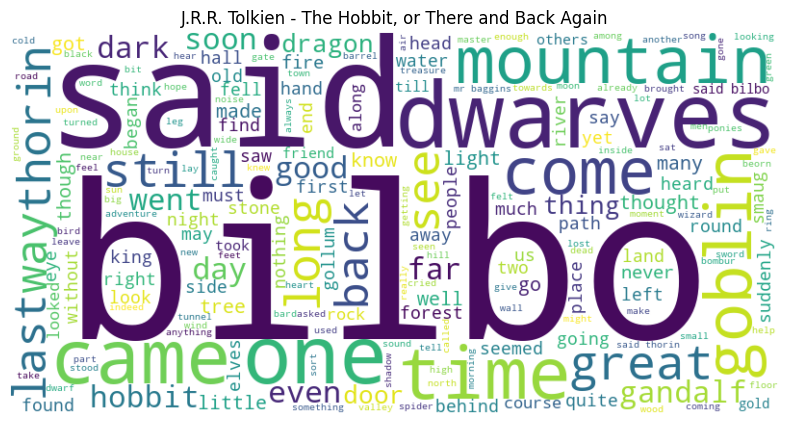

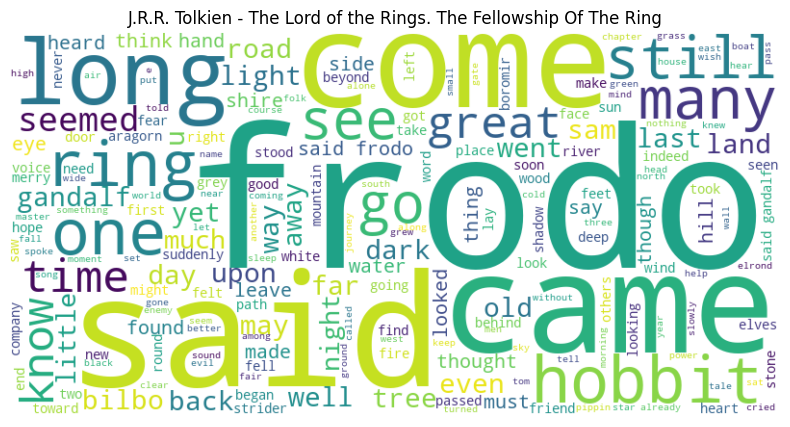

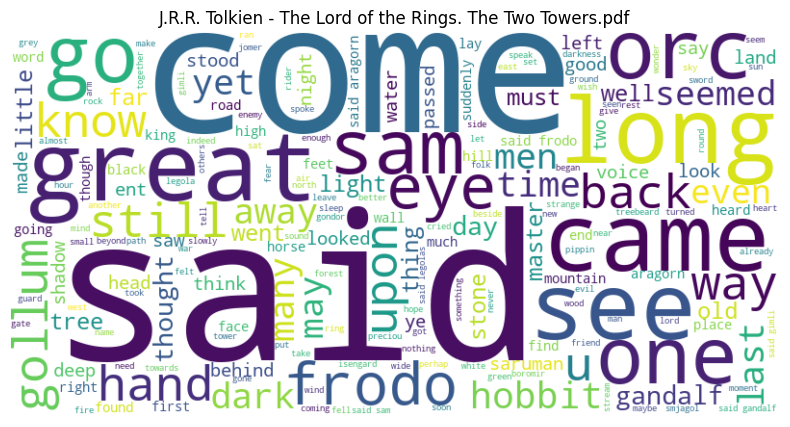

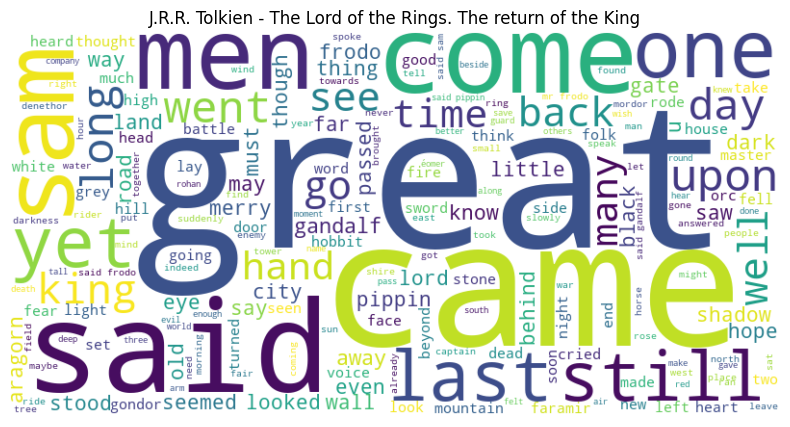

In [8]:
#Funkcja generująca chmurę słów i wyświetlająca ją na wykresie
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

#Generowanie chmur słów dla oczyszczonych książek
generate_wordcloud(book1_eng_cleaned, "J.R.R. Tolkien - The Hobbit, or There and Back Again")
generate_wordcloud(book2_eng_cleaned, "J.R.R. Tolkien - The Lord of the Rings. The Fellowship Of The Ring")
generate_wordcloud(book3_eng_cleaned, "J.R.R. Tolkien - The Lord of the Rings. The Two Towers.pdf")
generate_wordcloud(book4_eng_cleaned, "J.R.R. Tolkien - The Lord of the Rings. The return of the King")


# **Policzenie wszystkich słów w korpusie składającym się z 4 książek**

In [9]:
corpus = []
corpus.extend(book1_eng_cleaned)
corpus.extend(book2_eng_cleaned)
corpus.extend(book3_eng_cleaned)
corpus.extend(book4_eng_cleaned)

print("Liczba wszystkich słów w korpusie:", len(corpus))

Liczba wszystkich słów w korpusie: 277317


In [10]:
word_count = 0

for chapter in corpus:
    word_count += chapter.count("chapter")

print("Liczba wystąpień słowa 'chapter':", word_count)

Liczba wystąpień słowa 'chapter': 180


# **Podział książek na rozdziały**

Aby móc przeprowadzić proces klasyfikacji przedstawiony w kolejnym kroku, konieczne jest podzielenie książek na rozdziały. Jak można zauważyć powyżej, w korpusie składającym się ze wszystkich 4 książek słowo `chapter` występuje aż 180 razy, podczas gdy łączna liczba rozdziałów w całej sadze J.R.R. Tolkiena oscyluje w granicach 80. Wynika to z występowania w niektórych wersjach PDF spisu treści czy też sporadycznego pojawiania się tego wyrazu w tekście. Aby wyeliminować ten problem, zbudowano funkcję `split_into_chapters`. Ta metoda dzieli tekst na rozdziały w miejscach, gdzie przy wyrazie `chapter` występuje jakaś liczba. Dodatkowo pierwszy oraz trzeci tom Władcy Pierścieni w wersjach PDF wykorzystanych w projekcie zawierają obszerne spisy treści, zawierające nazwy rozdziałów również z innych części sagi. W celu uniknięcia sztucznego powstania większej liczby rozdziałów, te 2 książki zostały odczytane od strony po spisie treści, co zostało uwzględnione w funkcji `read_pdf` poprzez dodanie parametru `start_page`.

In [ ]:
def split_into_chapters(text):
    chapters = re.split(r'Chapter\s+\d+', text)
    #Usuwanie pustych rozdziałów
    chapters = [chapter.strip() for chapter in chapters if chapter.strip()]
    return chapters

def read_pdf(file_path, start_page = 0):
    with open(file_path, 'rb') as file:
        pdf_reader = PdfReader(file)
        num_pages = len(pdf_reader.pages)

        text = ''
        for page in pdf_reader.pages[start_page:]:
            text += page.extract_text()

        return text

def split_book_into_chapters(book_text):
    chapters = split_into_chapters(book_text)
    return chapters

In [ ]:
book1_eng = read_pdf('books\english books\J.R.R. Tolkien - The Hobbit, or There and Back Again.pdf')
book2_eng = read_pdf('books\english books\J.R.R. Tolkien - The Lord of the Rings. The Fellowship Of The Ring.pdf', start_page = 5)
book3_eng = read_pdf('books\english books\J.R.R. Tolkien - The Lord of the Rings. The Two Towers.pdf')
book4_eng = read_pdf('books\english books\J.R.R. Tolkien - The Lord of the Rings. The return of the King.pdf', start_page = 1)

In [ ]:
book1_eng_chapters = split_book_into_chapters(book1_eng)
book2_eng_chapters = split_book_into_chapters(book2_eng)
book3_eng_chapters = split_book_into_chapters(book3_eng)
book4_eng_chapters = split_book_into_chapters(book4_eng)

# **Policzenie rozdziałów w poszczególnych książkach**

Tekst został poprawnie podzielony na rozdziały. Liczba rozdziałów w poszczególnych częściach sagi J.R.R. Tolkiena obliczona metodą `split_book_into_chapters` jest zgodna z rzeczywistą liczbą rozdziałów w wersjach PDF wykorzystanych w projekcie.

In [ ]:
num_chapters_book1 = len(book1_eng_chapters)
num_chapters_book2 = len(book2_eng_chapters)
num_chapters_book3 = len(book3_eng_chapters)
num_chapters_book4 = len(book4_eng_chapters)

print("Liczba rozdziałów w Hobbit, czyli tam i z powrotem:", num_chapters_book1)
print("Liczba rozdziałów w Władca Pierścieni: Drużyna Pierścienia:", num_chapters_book2)
print("Liczba rozdziałów w Władca Pierścieni: Dwie wieże:", num_chapters_book3)
print("Liczba rozdziałów w Władca Pierścieni: Powrót króla:", num_chapters_book4)

Liczba rozdziałów w Hobbit, czyli tam i z powrotem: 19
Liczba rozdziałów w Władca Pierścieni: Drużyna Pierścienia: 23
Liczba rozdziałów w Władca Pierścieni: Dwie wieże: 22
Liczba rozdziałów w Władca Pierścieni: Powrót króla: 21


# **Budowa klasyfikatorów**

Proces klasyfikacji został przeprowadzony na podstawie rozdziałów uzyskanych za pomocą funkcji `split_book_into_chapters`. Klasyfikatory zostały zbudowane z wykorzystaniem naiwnego klasyfikatora bayesowskiego i wag binarnych, logarytmicznych oraz TF-IDF.

In [ ]:
#Utworzenie korpusu z podzielonych rozdziałów
corpus_chapters = book1_eng_chapters + book2_eng_chapters + book3_eng_chapters + book4_eng_chapters

#Tworzenie etykiet dla rozdziałów
labels = []
for i, chapters in enumerate([book1_eng_chapters, book2_eng_chapters, book3_eng_chapters, book4_eng_chapters]):
    labels += [i] * len(chapters)

#Utworzenie wektorów cech przy użyciu CountVectorizer z reprezentacją binarną
vectorizer_bin = CountVectorizer(analyzer='word', binary=True)
X_bin = vectorizer_bin.fit_transform(corpus_chapters)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train_bin, X_test_bin, y_train, y_test = train_test_split(X_bin, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja i trenowanie naiwnego klasyfikatora bayesowskiego z wagami binarnymi
classifier_nb_bin = MultinomialNB()
classifier_nb_bin.fit(X_train_bin, y_train)

#Utworzenie wektorów cech przy użyciu CountVectorizer z wagami logarytmicznymi
vectorizer_log = CountVectorizer(analyzer='word', binary=False)
X_log = vectorizer_log.fit_transform(corpus_chapters)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train_log, X_test_log, _, _ = train_test_split(X_log, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja i trenowanie naiwnego klasyfikatora bayesowskiego z wagami logarytmicznymi
classifier_nb_log = MultinomialNB()
classifier_nb_log.fit(X_train_log, y_train)

#Utworzenie wektorów cech przy użyciu TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(analyzer='word')
X_tfidf = vectorizer_tfidf.fit_transform(corpus_chapters)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja i trenowanie naiwnego klasyfikatora bayesowskiego z wagami TF-IDF
classifier_nb_tfidf = MultinomialNB()
classifier_nb_tfidf.fit(X_train_tfidf, y_train)

#Przewidywanie klas dla zbioru testowego
y_pred_bin = classifier_nb_bin.predict(X_test_bin)
y_pred_log = classifier_nb_log.predict(X_test_log)
y_pred_tfidf = classifier_nb_tfidf.predict(X_test_tfidf)

#Obliczenie dokładności klasyfikacji
accuracy_bin = accuracy_score(y_test, y_pred_bin)
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print("Dokładność klasyfikacji (reprezentacja binarna):", accuracy_bin)
print("Dokładność klasyfikacji (reprezentacja logarytmiczna):", accuracy_log)
print("Dokładność klasyfikacji (TF-IDF):", accuracy_tfidf)

#Macierz pomyłek
confusion_mat_nb_bin = confusion_matrix(y_test, y_pred_bin)
confusion_mat_nb_log = confusion_matrix(y_test, y_pred_log)
confusion_mat_nb_tfidf = confusion_matrix(y_test, y_pred_tfidf)

print("Macierz pomyłek (reprezentacja binarna):")
print(confusion_mat_nb_bin)

print("Macierz pomyłek (reprezentacja logarytmiczna):")
print(confusion_mat_nb_log)

print("Macierz pomyłek (TF-IDF):")
print(confusion_mat_nb_tfidf)

Dokładność klasyfikacji (reprezentacja binarna): 0.8235294117647058
Dokładność klasyfikacji (reprezentacja logarytmiczna): 0.8823529411764706
Dokładność klasyfikacji (TF-IDF): 0.47058823529411764
Macierz pomyłek (reprezentacja binarna):
[[4 0 0 0]
 [1 4 0 0]
 [0 0 4 0]
 [0 1 1 2]]
Macierz pomyłek (reprezentacja logarytmiczna):
[[4 0 0 0]
 [0 5 0 0]
 [0 0 4 0]
 [0 1 1 2]]
Macierz pomyłek (TF-IDF):
[[0 4 0 0]
 [0 5 0 0]
 [0 1 3 0]
 [0 4 0 0]]


Naiwny klasyfikator Bayesa z reprezentacją binarną:
<ul>
    <li>Dokładność klasyfikacji wynosi 82.35%. Oznacza to, że klasyfikator poprawnie przewiduje klasę rozdziału w około 82.35% przypadków.</li>
    <li>Macierz pomyłek pokazuje, że klasyfikator dokonał 4 poprawnych predykcji dla rozdziałów należących do pierwszej książki, 4 poprawnych predykcji dla rozdziałów należących do drugiej książki, 4 poprawnych predykcji dla rozdziałów należących do trzeciej książki oraz 2 poprawne predykcje dla rozdziałów należących do czwartej książki.</li>
</ul>
Naiwny klasyfikator Bayesa z reprezentacją logarytmiczną:
<ul>
    <li>Dokładność klasyfikacji wynosi 88.24%. Oznacza to, że klasyfikator poprawnie przewiduje klasę rozdziału w około 88.24% przypadków.</li>
    <li>Macierz pomyłek pokazuje, że klasyfikator dokonał 4 poprawnych predykcji dla rozdziałów należących do pierwszej książki, 5 poprawnych predykcji dla rozdziałów należących do drugiej książki, 4 poprawnych predykcji dla rozdziałów należących do trzeciej książki oraz 2 poprawne predykcje dla rozdziałów należących do czwartej książki.</li>
</ul>
Naiwny klasyfikator Bayesa z reprezentacją TF-IDF:
<ul>
    <li>Dokładność klasyfikacji wynosi 47.06%. Oznacza to, że klasyfikator poprawnie przewiduje klasę rozdziału jedynie w około 47.06% przypadków, co jest wynikiem niższym niż w przypadku pozostałych reprezentacji wag.</li>
    <li>Macierz pomyłek pokazuje, że klasyfikator ma trudności w poprawnej klasyfikacji rozdziałów. Występuje wiele pomyłek, szczególnie dla rozdziałów należących do pierwszej i drugiej książki, gdzie wiele rozdziałów jest błędnie przypisywanych do innych klas.</li>
</ul>

Analizując powyższe wyniki procesu klasyfikacji, można wywnioskować, iż najlepszą dokładność klasyfikacji uzyskano dla naiwnego klasyfikatora Bayesa wykorzystującego wagi logarytmiczne. Najniższą dokładnością natomiast wykazała się reprezentacja TF-IDF, co może sugerować, że w przypadku tego zbioru danych, nie jest ona odpowiednia dla procesu klasyfikacji rozdziałów do odpowiednich książek.